In [ ]:
import pandas as pd

# 데이터 불러오기!
train_df = pd.read_csv('data/train.csv')
test_y = pd.read_csv('data/test.csv')
"""
pressure 압력
maxtemp 최대온도
temperature 온도
mintemp 최소온도
dewpoint 이슬점
humidity 습기
cloud 구름
sunshine 햇빛
wind direction 바람의 방향
wind speed 풍속
rainfall 강우
"""
train_df = train_df.drop(columns=['id', 'day', 'winddirection'])
test_y = test_y.drop(columns=['id', 'day', 'winddirection'])


# ㅈ대로하는 피처 엔지니어링 .
print(train_df.head())
# humity, sunshine
# train_df['3colmns'] = train_df['dewpoint'] + train_df['cloud'] + train_df['humidity']

# train_df['cloudshine'] = train_df['sunshine'] / train_df['cloud']
# test_y['cloudshine'] = test_y['sunshine'] / test_y['cloud']
# train_df['dewpointhumidity'] = train_df['cloud'] + train_df['dewpoint']
# test_y['dewpointhumidity'] = test_y['cloud'] + test_y['dewpoint']
# test_y['cloudhumidity'] = test_y['cloud'] * test_y['humidity']

   pressure  maxtemp  temparature  mintemp  dewpoint  humidity  cloud  \
0    1017.4     21.2         20.6     19.9      19.4      87.0   88.0   
1    1019.5     16.2         16.9     15.8      15.4      95.0   91.0   
2    1024.1     19.4         16.1     14.6       9.3      75.0   47.0   
3    1013.4     18.1         17.8     16.9      16.8      95.0   95.0   
4    1021.8     21.3         18.4     15.2       9.6      52.0   45.0   

   sunshine  windspeed  rainfall  
0       1.1       17.2         1  
1       0.0       21.9         1  
2       8.3       18.1         1  
3       0.0       35.6         1  
4       3.6       24.8         0  


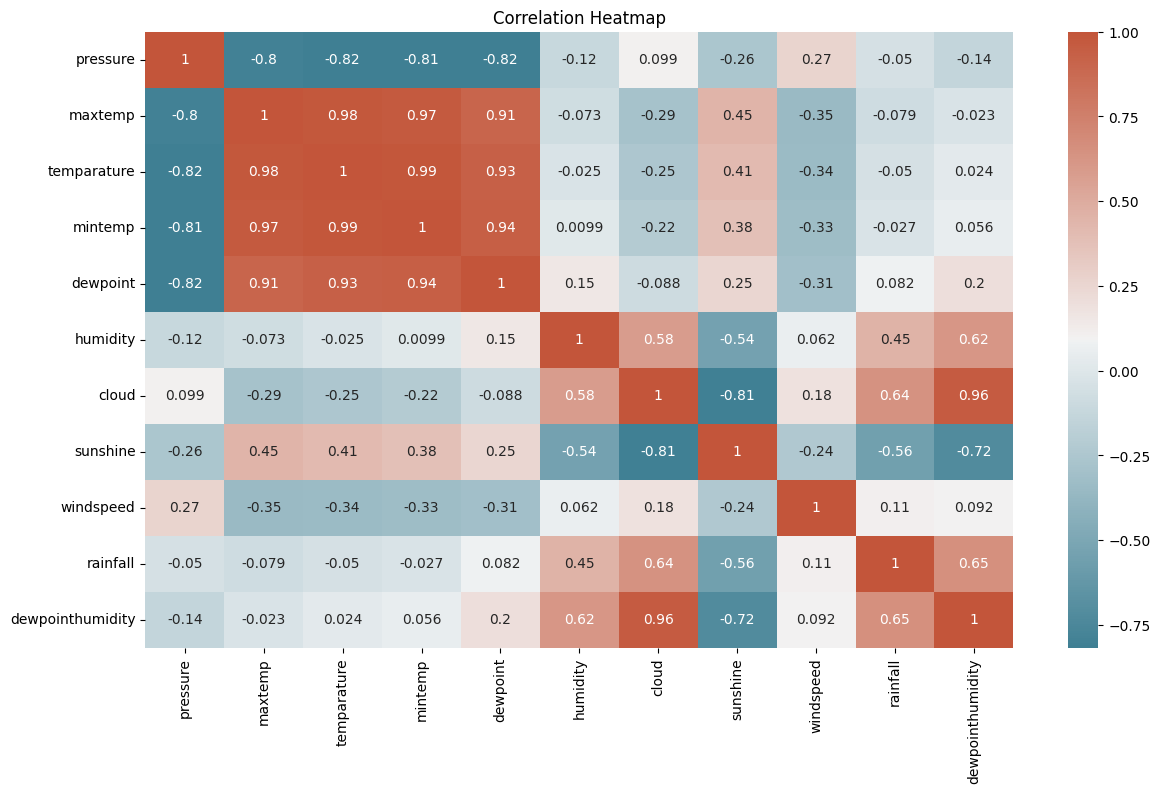

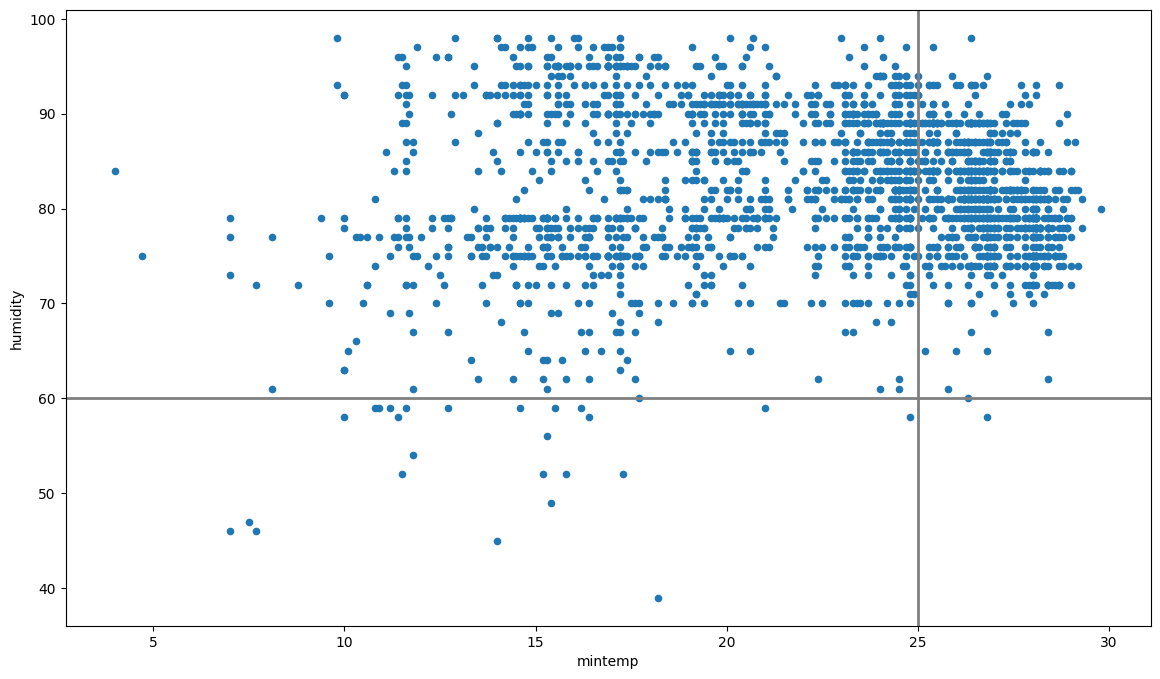

In [27]:
# 일변량 분석
# train_df = train_df[train_df['rainfall']==1]
# print(train_df)

df = train_df.select_dtypes(include=['number'])

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 8)

corr_matrix = df.corr()

# print(corr_matrix.loc[corr_matrix['Transported'].abs() >= 0.1].index.tolist())
sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

ax = train_df.plot.scatter(x='mintemp', y='humidity')
ax.axhline(60, color='gray', lw=2)
ax.axvline(25, color='gray', lw=2)

Text(0, 0.5, 'humidity')

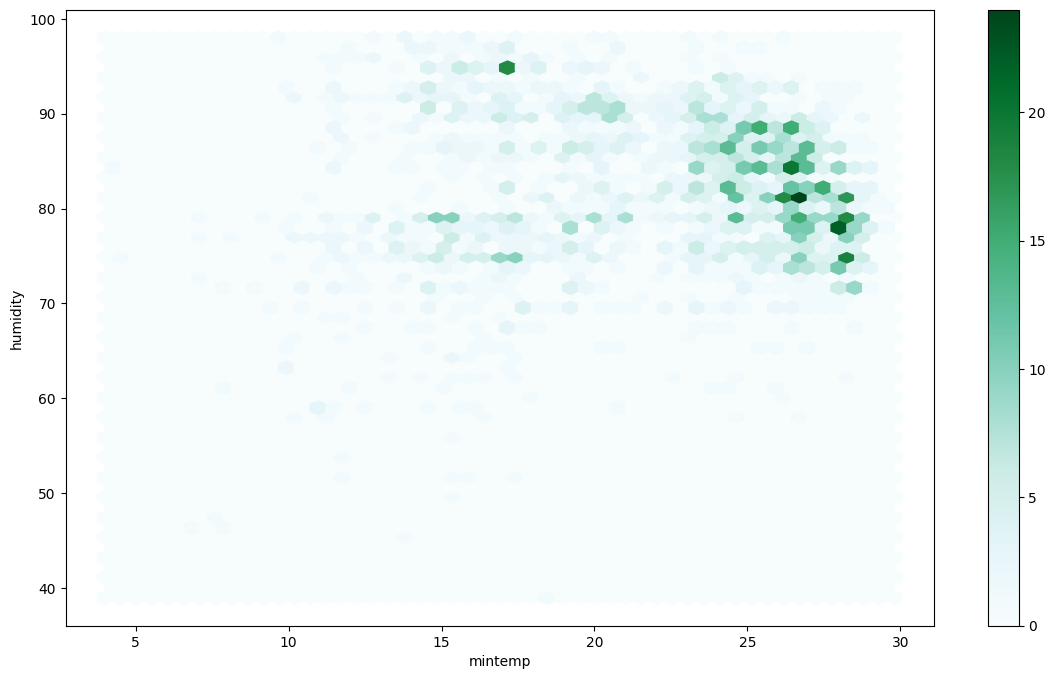

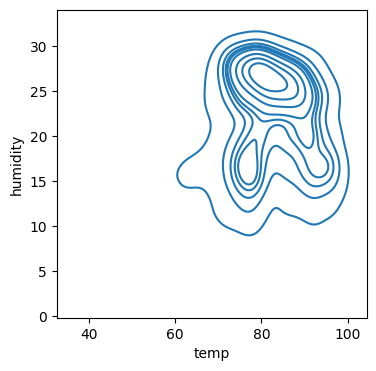

In [28]:
# 다변량 분석
train_df.plot.hexbin(x='mintemp', y='humidity', gridsize=50, sharex=False)
ax.set_xlabel('FInished min temp')
ax.set_ylabel("temperature")

fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.kdeplot(data=train_df, x='humidity', y='mintemp', ax=ax)
ax.set_xlabel('temp')
ax.set_ylabel('humidity')



In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMClassifier

X = train_df.select_dtypes(include=['number'])
y = train_df.rainfall
X = X.drop(columns=['rainfall'])

cat_model = CatBoostClassifier(iterations=500, learning_rate=0.04, depth=5, verbose=0)
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.04, max_depth=3, eval_metric='auc')
svm_model = SVC(probability=True, kernel='rbf', C=1.0)
knn_model = KNeighborsClassifier(n_neighbors=5)
lgbm_model = LGBMClassifier(objective='binary', metric='auc')

estimators = [
    ('cat', cat_model),
    ('lgbm', lgbm_model),
    ('xgb', xgb_model)
]

from sklearn.metrics import roc_auc_score



model = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier(n_estimators=100))
test_y = test_y[X.columns].fillna(0)
test_y = test_y.select_dtypes(include=['number'])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)


# 2. 모델 학습
model.fit(X_train, y_train)

# 3. Validation에 대해 확신 높은 예측 선택 (여기서만 생성)
val_proba = model.predict_proba(X_val)[:, 1]
high_conf_mask = (val_proba > 0.95) | (val_proba < 0.05)

pseudo_X = X_val[high_conf_mask]
pseudo_y = (val_proba[high_conf_mask] > 0.55).astype(int)

# 4. 원래 훈련셋과 결합
X_pseudo = pd.concat([X_train, pseudo_X])
y_pseudo = pd.concat([pd.Series(y_train), pd.Series(pseudo_y)])

# 5. 새로 학습
model.fit(X_pseudo, y_pseudo)

# 6. 성능 확인
y_pred = model.predict(X_val)

print("Val accuracy after pseudo labeling:", accuracy_score(y_val, y_pred))
y_proba = model.predict_proba(X_val)[:, 1]  # 양성 클래스 확률만 추출
auc = roc_auc_score(y_val, y_pred)
print("ROC AUC:", auc)

# 7. 최종 테스트셋 예측
final_pred = model.predict(test_y)
# ROC AUC: 0.7775210084033612
# ROC AUC: 0.7884453781512604
# 0.7809873949579831

[LightGBM] [Info] Number of positive: 1242, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1511
[LightGBM] [Info] Number of data points in the train set: 1642, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.756395 -> initscore=1.133014
[LightGBM] [Info] Start training from score 1.133014
[LightGBM] [Info] Number of positive: 993, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1426
[LightGBM] [Info] Number of data points in the train set: 1313, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.756283 -> initscore=1.132410
[LightGBM] [Info] Start training from score 1.132410
[LightGBM] [Info] Number 

In [30]:
template_df = pd.read_csv('data/test.csv')
dd = template_df['id']

# int(dd)
ddf = pd.Series(final_pred, name='rainfall')
# ddf = ddf.map({0: 'False', 1: 'True'})
ds = pd.concat([dd ,ddf], axis=1)
print(ds)
ds.to_csv("result.csv", index=False)

       id  rainfall
0    2190         1
1    2191         1
2    2192         1
3    2193         0
4    2194         0
..    ...       ...
725  2915         1
726  2916         1
727  2917         1
728  2918         1
729  2919         1

[730 rows x 2 columns]
